In [1]:
import pandas as pd
import re
from scipy.signal import correlate
import numpy as np
import sys
sys.path.append(r'C:\Users\clima\Desktop\Aptamers\src')
import time
from sklearn.manifold import TSNE
from sklearn.cluster import OPTICS
import os
from APTamers import  Aptamer_Fold
from tqdm import tqdm
from utils import check_char, check_if_string, check_structure, check_empty_or_short, find_substrings,  attach_stems
import pandas as pd
import forgi.visual.mplotlib as fvm
import forgi
import RNA
from forgi.graph.bulge_graph import BulgeGraph
import matplotlib.pyplot as plt
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.cluster import SpectralClustering
from seqfold import fold, dg, dg_cache, dot_bracket

In [2]:
df = pd.read_csv(r'C:\Users\clima\Desktop\Aptamers\data\preprocessed _files\UNAfold_merged_all.csv')
print('Numeber sequences after merge:',len(df))
df = df.drop_duplicates(subset='Sequence')
print('Numeber of unique sequences after preprocessing:',len(df))

percentile_95 = np.percentile(df['Sequence'].apply(len), 95) 
percentile_3 = np.percentile(df['Sequence'].apply(len), 5)
# Filter DataFrame to remove rows with list lengths outside the 95th percentile
df = df[df['Sequence'].apply(len).between(0, np.ceil(percentile_95))]
df = df[df['Sequence'].apply(len) > np.floor(percentile_3)]
df.reset_index()
BpEnergy = {
    "AGAAT": (-1.5, 0.0),
    "AGCAT": (-1.5, 0.0),
    "AGGAT": (-1.5, 0.0),
    "AGTAT": (-1.5, 0.0),
    "CGAAG": (-2.0, 0.0),
    "CGCAG": (-2.0, 0.0),
    "CGGAG": (-2.0, 0.0),
    "CGTAG": (-2.0, 0.0),
    "GGAAC": (-2.0, 0.0),
    "GGCAC": (-2.0, 0.0),
    "GGGAC": (-2.0, 0.0),
    "GGTAC": (-2.0, 0.0),
    "TGAAA": (-1.5, 0.0),
    "TGCAA": (-1.5, 0.0),
    "TGGAA": (-1.5, 0.0),
    "TGTAA": (-1.5, 0.0),
    "AAAAAT": (0.5, 0.6),
    "AAAACT": (0.7, -1.6),
    "AAACAT": (1.0, -1.6),
    "ACTTGT": (0.0, -4.2),
    "AGAAAT": (-1.1, -1.6),
    "AGAGAT": (-1.1, -1.6),
    "AGATAT": (-1.5, -1.6),
    "AGCAAT": (-1.6, -1.6),
    "AGCGAT": (-1.1, -1.6),
    "AGCTTT": (0.2, -1.6),
    "AGGAAT": (-1.1, -1.6),
    "AGGGAT": (-1.1, -1.6),
    "AGGGGT": (0.5, -0.6),
    "AGTAAT": (-1.6, -1.6),
    "AGTGAT": (-1.1, -1.6),
    "AGTTCT": (0.8, -1.6),
    "ATTCGT": (-0.2, -1.6),
    "ATTTGT": (0.0, -1.6),
    "ATTTTT": (-0.5, -1.6),
    "CAAAAG": (0.5, 1.3),
    "CAAACG": (0.7, 0.0),
    "CAACAG": (1.0, 0.0),
    "CAACCG": (0.0, 0.0),
    "CCTTGG": (0.0, -2.6),
    "CGAAAG": (-1.1, 0.0),
    "CGAGAG": (-1.1, 0.0),
    "CGATAG": (-1.5, 0.0),
    "CGCAAG": (-1.6, 0.0),
    "CGCGAG": (-1.1, 0.0),
    "CGCTTG": (0.2, 0.0),
    "CGGAAG": (-1.1, 0.0),
    "CGGGAG": (-1.0, 0.0),
    "CGGGGG": (0.5, 1.0),
    "CGTAAG": (-1.6, 0.0),
    "CGTGAG": (-1.1, 0.0),
    "CGTTCG": (0.8, 0.0),
    "CTTCGG": (-0.2, 0.0),
    "CTTTGG": (0.0, 0.0),
    "CTTTTG": (-0.5, 0.0),
    "GAAAAC": (0.5, 3.2),
    "GAAACC": (0.7, 0.0),
    "GAACAC": (1.0, 0.0),
    "GCTTGC": (0.0, -2.6),
    "GGAAAC": (-1.1, 0.0),
    "GGAGAC": (-1.1, 0.0),
    "GGATAC": (-1.6, 0.0),
    "GGCAAC": (-1.6, 0.0),
    "GGCGAC": (-1.1, 0.0),
    "GGCTTC": (0.2, 0.0),
    "GGGAAC": (-1.1, 0.0),
    "GGGGAC": (-1.1, 0.0),
    "GGGGGC": (0.5, 1.0),
    "GGTAAC": (-1.6, 0.0),
    "GGTGAC": (-1.1, 0.0),
    "GGTTCC": (0.8, 0.0),
    "GTTCGC": (-0.2, 0.0),
    "GTTTGC": (0.0, 0.0),
    "GTTTTC": (-0.5, 0.0),
    "GAAAAT": (0.5, 3.2),
    "GAAACT": (1.0, 0.0),
    "GAACAT": (1.0, 0.0),
    "GCTTGT": (0.0, -1.6),
    "GGAAAT": (-1.1, 0.0),
    "GGAGAT": (-1.1, 0.0),
    "GGATAT": (-1.6, 0.0),
    "GGCAAT": (-1.6, 0.0),
    "GGCGAT": (-1.1, 0.0),
    "GGCTTT": (-0.1, 0.0),
    "GGGAAT": (-1.1, 0.0),
    "GGGGAT": (-1.1, 0.0),
    "GGGGGT": (0.5, 1.0),
    "GGTAAT": (-1.6, 0.0),
    "GGTGAT": (-1.1, 0.0),
    "GTATAT": (-0.5, 0.0),
    "GTTCGT": (-0.4, 0.0),
    "GTTTGT": (-0.4, 0.0),
    "GTTTTT": (-0.5, 0.0),
    "TAAAAA": (0.5, -0.3),
    "TAAACA": (0.7, -1.6),
    "TAACAA": (1.0, -1.6),
    "TCTTGA": (0.0, -4.2),
    "TGAAAA": (-1.1, -1.6),
    "TGAGAA": (-1.1, -1.6),
    "TGATAA": (-1.6, -1.6),
    "TGCAAA": (-1.6, -1.6),
    "TGCGAA": (-1.1, -1.6),
    "TGCTTA": (0.2, -1.6),
    "TGGAAA": (-1.1, -1.6),
    "TGGGAA": (-1.1, -1.6),
    "TGGGGA": (0.5, -0.6),
    "TGTAAA": (-1.6, -1.6),
    "TGTGAA": (-1.1, -1.6),
    "TGTTCA": (0.8, -1.6),
    "TTTCGA": (-0.2, -1.6),
    "TTTTGA": (0.0, -1.6),
    "TTTTTA": (-0.5, -1.6),
    "TAAAAG": (0.5, 1.6),
    "TAAACG": (1.0, -1.6),
    "TAACAG": (1.0, -1.6),
    "TCTTGG": (0.0, -3.2),
    "TGAAAG": (-1.0, -1.6),
    "TGAGAG": (-1.0, -1.6),
    "TGATAG": (-1.5, -1.6),
    "TGCAAG": (-1.5, -1.6),
    "TGCGAG": (-1.0, -1.6),
    "TGCTTG": (-0.1, -1.6),
    "TGGAAG": (-1.0, -1.6),
    "TGGGAG": (-1.0, -1.6),
    "TGGGGG": (0.5, -0.6),
    "TGTAAG": (-1.5, -1.6),
    "TGTGAG": (-1.0, -1.6),
    "TTTCGG": (-0.4, -1.6),
    "TTTTAG": (-1.0, -1.6),
    "TTTTGG": (-0.4, -1.6),
    "TTTTTG": (-0.5, -1.6),
}

subsequence = list(BpEnergy.keys())

Numeber sequences after merge: 4933
Numeber of unique sequences after preprocessing: 4933


In [3]:
def find_consecutive_dots(string):
    dot_locations = []  # List to store locations of consecutive dots
    consecutive_dots = []  # List to store consecutive dot sequences

    for i, char in enumerate(string):
        if char == '.':
            dot_locations.append(i)
        else:
            if len(dot_locations) > 0:
                consecutive_dots.append(dot_locations)
            dot_locations = []

    return consecutive_dots


def bag_of_sequences(subsequence, sequence, consecutive_dots):
    desc = np.zeros(len(subsequence), dtype = int)
    for count, sub in enumerate(subsequence):
        for m in consecutive_dots:
                lis =  ''.join([sequence[n] for n in m])
                if sub in lis:
                    desc[count]+=1
    return desc
                    
def descriptors(sequence, structure):
    consecutive_dots = find_consecutive_dots(structure)
    return bag_of_sequences(subsequence, sequence, consecutive_dots)
    
    
def compute_descriptor(input_string):
    descriptor = []
    sum = 0
    for  char in input_string:
        if char == '(':
            sum +=1
            descriptor.append(sum)
        elif char == ')':
            sum -=1 
            descriptor.append(sum)
        elif char == '.':
            descriptor.append(sum)      
    return descriptor

def dna_descriptor(sequence, n_max):
    # Create an array of zeros with the same length as the sequence
    complete_descriptor = []
    for l in ['A', 'C', 'T', 'G']:
        descriptor = np.zeros(len(sequence), dtype=int)
        descriptor[ np.where(np.array(list(sequence)) == l)[0]] = 1
        
        complete_descriptor +=descriptor.tolist()
        complete_descriptor+=np.zeros(n_max -len(sequence), dtype=int).tolist()
    return np.asarray(complete_descriptor)               

# Descritpors Mat

(4450, 73)
(4450, 73)


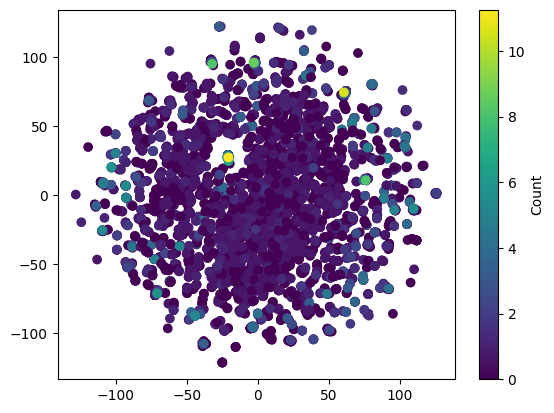

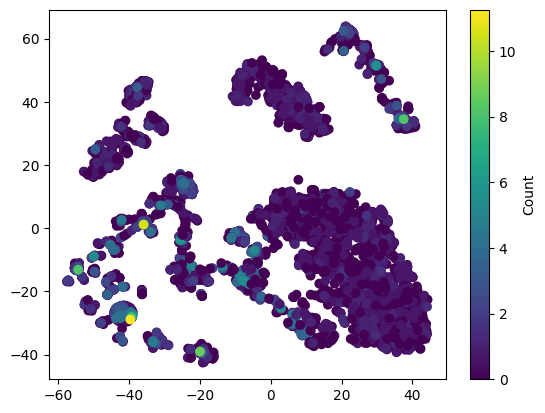

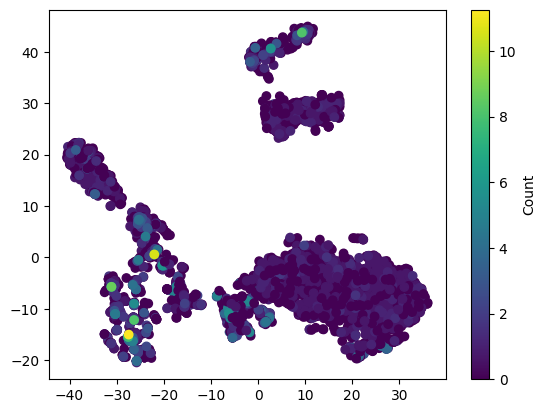

In [15]:
df['Descriptor'] = df['Structure_UNA'].apply(lambda x: compute_descriptor(x) )
df['Descriptor'] = df['Descriptor'] .apply(lambda x: np.array(x[8:-8]))
# Determine the maximum length of the lists
max_length = df['Descriptor'].apply(len).max()

# Convert the lists column into a numpy array with padding
X = np.zeros((len(df), max_length), dtype=int)
#X= np.zeros((len(df), len(subsequence)), dtype=int)
for i, row in enumerate(df['Descriptor']):
    X[i,:len(row)] = row
 
    
print(X.shape)
def remove_zero_features(data):
    # Iterate through each feature
    zero_features = np.all(data == 0, axis=0)
    
    # Find indices of features to keep
    nonzero_indices = np.where(~zero_features)[0]
    
    # Filter data matrix to keep only non-zero features
    filtered_data = data[:, nonzero_indices]
    
    return filtered_data

X = remove_zero_features(X)
print(X.shape)

idx = df['Count'] >= 1000

X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', random_state=42, perplexity=3).fit_transform(X)
X_embedded = X_embedded
colors =np.log(df['Count'])
plt.scatter(X_embedded[::-1,0], X_embedded[::-1,1],c=colors [::-1], cmap='viridis')

plt.colorbar(label='Count')
plt.show()


X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', random_state=42, perplexity=50).fit_transform(X)
X_embedded = X_embedded
colors =np.log(df['Count'])
plt.scatter(X_embedded[::-1,0], X_embedded[::-1,1],c=colors [::-1], cmap='viridis')

plt.colorbar(label='Count')
plt.show()

X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', random_state=42, perplexity=150).fit_transform(X)
X_embedded = X_embedded
colors =np.log(df['Count'])
plt.scatter(X_embedded[::-1,0], X_embedded[::-1,1],c=colors[::-1], cmap='viridis')
#plt.scatter(X_embedded[idx,0], X_embedded[idx,1])
plt.colorbar(label='Count')
plt.show()

# Descriptors Bag of Sequences

(4450, 131)
(4450, 123)


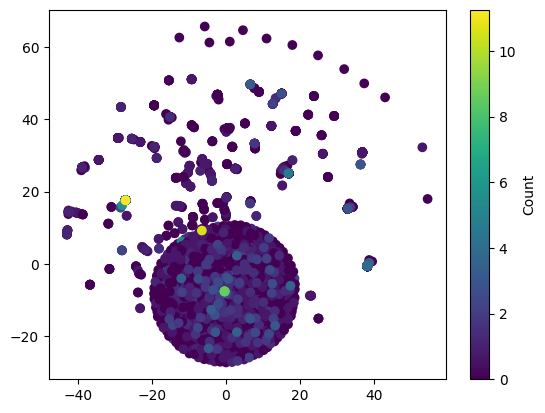

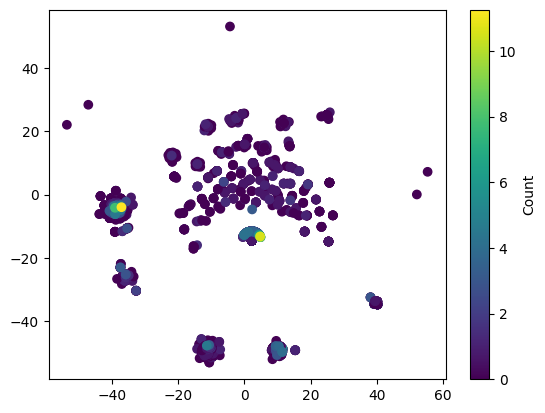

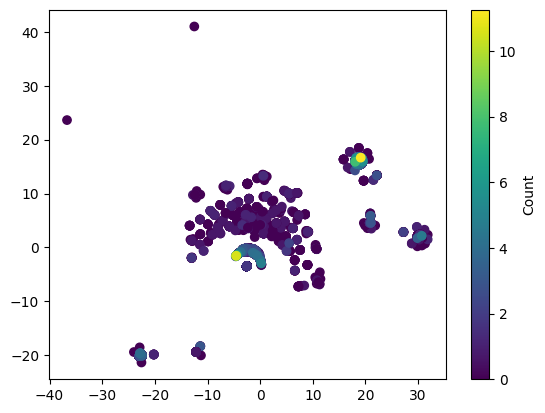

In [4]:

# Convert the lists column into a numpy array with padding
#X = np.zeros((len(df), max_length + len(subsequence)), dtype=int)
X= np.zeros((len(df), len(subsequence)), dtype=int)
for count, (seq, str) in enumerate(zip(df['Sequence'], df['Structure_UNA'])):
    X[count, :] =  descriptors(seq, str)
    
    
print(X.shape)
def remove_zero_features(data):
    # Iterate through each feature
    zero_features = np.all(data == 0, axis=0)
    
    # Find indices of features to keep
    nonzero_indices = np.where(~zero_features)[0]
    
    # Filter data matrix to keep only non-zero features
    filtered_data = data[:, nonzero_indices]
    
    return filtered_data

X = remove_zero_features(X)
print(X.shape)

idx = df['Count'] >= 1000

X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', random_state=42, perplexity=5).fit_transform(X)
X_embedded = X_embedded
colors =np.log(df['Count'])
plt.scatter(X_embedded[::-1,0], X_embedded[::-1,1],c=colors [::-1], cmap='viridis')

plt.colorbar(label='Count')
plt.show()

X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', random_state=42, perplexity=50).fit_transform(X)
X_embedded = X_embedded
colors =np.log(df['Count'])
plt.scatter(X_embedded[::-1,0], X_embedded[::-1,1],c=colors [::-1], cmap='viridis')

plt.colorbar(label='Count')
plt.show()

X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', random_state=42, perplexity=150).fit_transform(X)
X_embedded = X_embedded
colors =np.log(df['Count'])
plt.scatter(X_embedded[::-1,0], X_embedded[::-1,1],c=colors[::-1], cmap='viridis')
#plt.scatter(X_embedded[idx,0], X_embedded[idx,1])
plt.colorbar(label='Count')
plt.show()

(4450, 204)
(4450, 196)


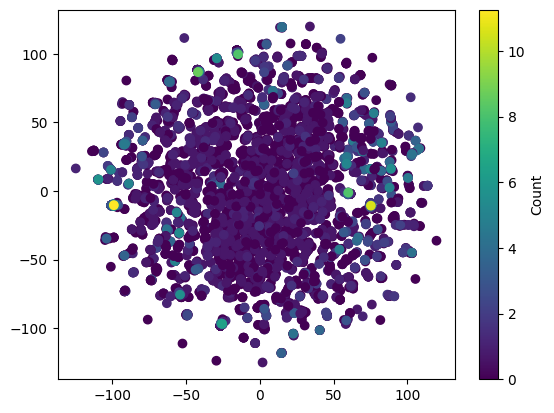

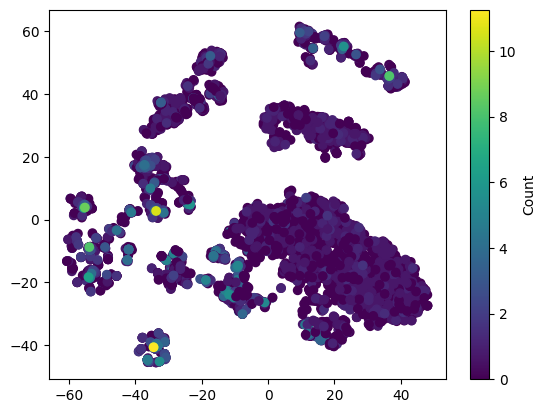

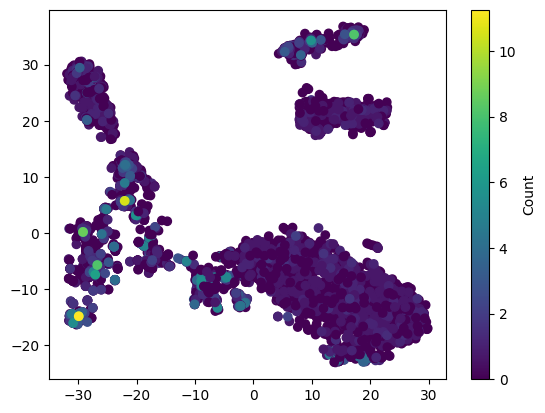

In [21]:
df['Descriptor'] = df['Structure_UNA'].apply(lambda x: compute_descriptor(x) )
df['Descriptor'] = df['Descriptor'] .apply(lambda x: np.array(x[8:-8]))
# Determine the maximum length of the lists
max_length = df['Descriptor'].apply(len).max()

# Convert the lists column into a numpy array with padding
X = np.zeros((len(df), max_length + len(subsequence)), dtype=int)
#X= np.zeros((len(df), len(subsequence)), dtype=int)
for count, (desc, seq, str) in enumerate(zip(df['Descriptor'],df['Sequence'], df['Structure_UNA'])):
    X[count, max_length :] =  8*descriptors(seq, str)
    X[count,:len(desc)] = desc
  
print(X.shape)
def remove_zero_features(data):
    # Iterate through each feature
    zero_features = np.all(data == 0, axis=0)
    
    # Find indices of features to keep
    nonzero_indices = np.where(~zero_features)[0]
    
    # Filter data matrix to keep only non-zero features
    filtered_data = data[:, nonzero_indices]
    
    return filtered_data

X = remove_zero_features(X)
print(X.shape)

idx = df['Count'] >= 1000


X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', random_state=42, perplexity=3).fit_transform(X)
X_embedded = X_embedded
colors =np.log(df['Count'])
plt.scatter(X_embedded[::-1,0], X_embedded[::-1,1],c=colors [::-1], cmap='viridis')

plt.colorbar(label='Count')
plt.show()

X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', random_state=42, perplexity=50).fit_transform(X)
X_embedded = X_embedded
colors =np.log(df['Count'])
plt.scatter(X_embedded[::-1,0], X_embedded[::-1,1],c=colors [::-1], cmap='viridis')

plt.colorbar(label='Count')
plt.show()

X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', random_state=42, perplexity=150).fit_transform(X)
X_embedded = X_embedded
colors =np.log(df['Count'])
plt.scatter(X_embedded[::-1,0], X_embedded[::-1,1],c=colors[::-1], cmap='viridis')
#plt.scatter(X_embedded[idx,0], X_embedded[idx,1])
plt.colorbar(label='Count')
plt.show()

In [ ]:
df['Descriptor'] = df['Structure_UNA'].apply(lambda x: compute_descriptor(x) )
#df['Descriptor'] = df['Descriptor'] .apply(lambda x: np.array(x))
df['Descriptor'] = df['Descriptor'] .apply(lambda x: np.array(x[8:-8])-8)
# Determine the maximum length of the lists
max_length = df['Descriptor'].apply(len).max()

# Convert the lists column into a numpy array with padding

X= np.zeros((len(df), len(subsequence)), dtype=int)
for i, row in enumerate(df['Descriptor']):
    X[i] = descriptors(df['Sequence'][i], df['Structure_UNA'][i])
    
print(X.shape)
def remove_zero_features(data):
    # Iterate through each feature
    zero_features = np.all(data == 0, axis=0)
    
    # Find indices of features to keep
    nonzero_indices = np.where(~zero_features)[0]
    
    # Filter data matrix to keep only non-zero features
    filtered_data = data[:, nonzero_indices]
    
    return filtered_data

X = remove_zero_features(X)
print(X.shape)

idx = df['Count'] >= 1000


X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', random_state=42, perplexity=50).fit_transform(X)
X_embedded = X_embedded
colors =np.log(df['Count'])
plt.scatter(X_embedded[::-1,0], X_embedded[::-1,1],c=colors [::-1], cmap='viridis')

plt.colorbar(label='Count')
plt.show()

X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', random_state=42, perplexity=120).fit_transform(X)
X_embedded = X_embedded
colors =np.log(df['Count'])
plt.scatter(X_embedded[::-1,0], X_embedded[::-1,1],c=colors[::-1], cmap='viridis')
#plt.scatter(X_embedded[idx,0], X_embedded[idx,1])
plt.colorbar(label='Count')
plt.show()

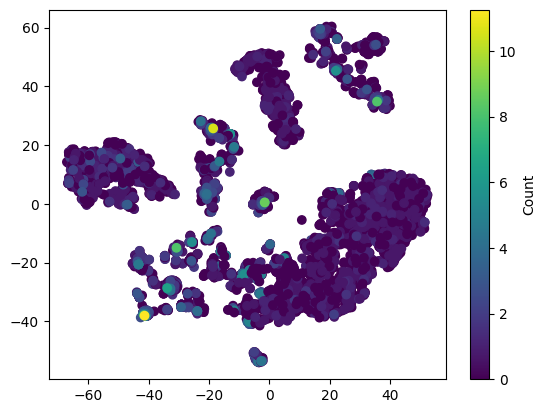

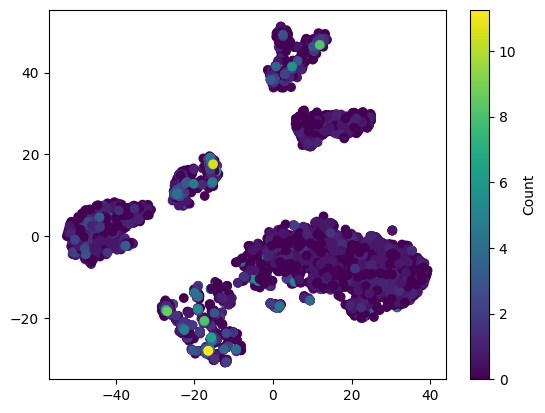

In [9]:
def find_hairpin_loops(dot_bracket):
    hairpin_loops = []
    stack = []

    for i, char in enumerate(dot_bracket):
        if char == '(':
            stack.append(i)
        elif char == ')':
            if stack:
                start = stack.pop()
                loop_start = start + 1
                loop_end = i - 1
                loop= dot_bracket[loop_start:loop_end + 1]
                # Check if the region between start and i is a hairpin loop
                if loop.count('.') > 0 and '(' not in loop and ')' not in loop:
                    hairpin_loops.append((loop_start, loop_end + 1))

    return hairpin_loops


def find_bulges(dot_bracket, max_bulge_length=3):
    bulges = []
    stack = []

    for i, char in enumerate(dot_bracket):
        if char == '(':
            stack.append(i)
        elif char == ')':
            if stack:
                start = stack.pop()
                loop_start = start + 1
                loop_end = i - 1

                # Check if the region between start and i is a bulge
                if dot_bracket[loop_start:loop_end + 1].count('.') > 0:
                    bulge_start = loop_start
                    bulge_end = loop_end

                    # Adjust the bulge boundaries based on adjacent base pairs
                    while bulge_start > 0 and dot_bracket[bulge_start - 1] == '.':
                        bulge_start -= 1
                    while bulge_end < len(dot_bracket) - 1 and dot_bracket[bulge_end + 1] == '.':
                        bulge_end += 1

                    # Check if the bulge meets the maximum length constraint
                    if bulge_end - bulge_start + 1 <= max_bulge_length:
                        bulges.append((bulge_start, bulge_end - bulge_start + 1))

    return bulges

# Example usage:
dot_bracket_notation = df['Structure_UNA'][0]
bulges = find_hairpin_loops(dot_bracket_notation)
print("Bulges found:", bulges)


dot_bracket_notation = df['Structure_graph_match'][0]
bulges = find_hairpin_loops(dot_bracket_notation)
print("Bulges found:", bulges)



Bulges found: [(15, 18), (36, 39)]
Bulges found: [(19, 26)]


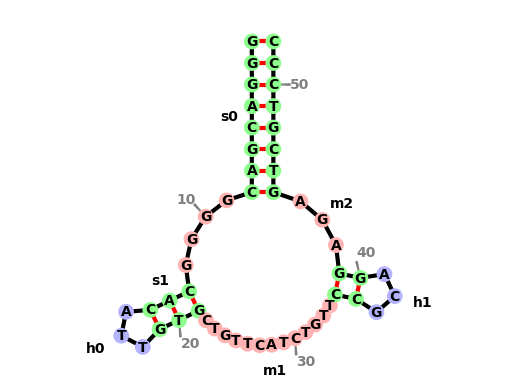

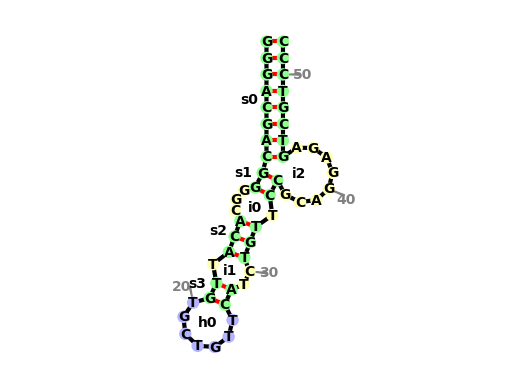

In [8]:
seqs = Aptamer_Fold().fit_fold(sequence= df['Sequence'][0],  n_tmpl=4, l_fix=8 ,  return_min = False, filters = False)
bg = BulgeGraph.from_dotbracket( df['Structure_UNA'][0] ,  df['Sequence'][0] )

fvm.plot_rna(bg, text_kwargs={"fontweight":"black"}, lighten=0.7,backbone_kwargs={"linewidth":3})
plt.show()

bg = BulgeGraph.from_dotbracket( df['Structure_graph_match'][0] ,  df['Sequence'][0] )

fvm.plot_rna(bg, text_kwargs={"fontweight":"black"}, lighten=0.7,backbone_kwargs={"linewidth":3})
plt.show()